In [ ]:
# https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

# Load dataset

In [9]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir='COVID-19_Radiography_Dataset/jpeg')

c:\Users\jonpg\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 16876 examples [00:03, 5501.89 examples/s]
Generating test split: 4289 examples [00:00, 5478.67 examples/s]


In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 16876
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 4289
    })
})

In [11]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [12]:
id2label

{'0': 'covid', '1': 'lung_opacity', '2': 'normal', '3': 'viral_pneumonia'}

# Preprocess data

In [13]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

c:\Users\jonpg\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jonpg\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Fast image processor class <class 'transformers.models.vit.image_processing_

In [14]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [15]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [16]:
images = dataset.with_transform(transforms)

In [17]:
images

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 16876
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 4289
    })
})

In [18]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

# Evaluate

In [21]:
import evaluate

accuracy = evaluate.load("accuracy")

In [22]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [23]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
training_args = TrainingArguments(
    output_dir="covid_radiology_classification",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=images["train"],
    eval_dataset=images["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)



In [31]:
trainer.train()

  0%|          | 0/263 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [133]:
trainer.save_model('covid_radiology_classification')

# Inference

In [26]:
index = 10000
test_image = dataset['train'][index]['image']
dataset['train'][index]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=299x299>,
 'label': 2}

In [27]:
dataset['train'][index]['label']

2

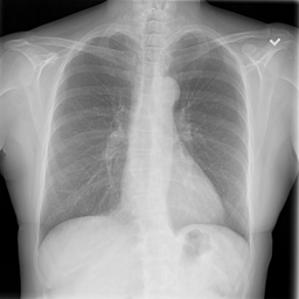

In [28]:
test_image

In [29]:
from transformers import pipeline

classifier = pipeline("image-classification", model="covid_radiology_classification")
classifier(test_image)

OSError: covid_radiology_classification does not appear to have a file named config.json. Checkout 'https://huggingface.co/covid_radiology_classification/tree/None' for available files.

In [139]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("covid_radiology_classification")
inputs = image_processor(test_image, return_tensors="pt")

In [152]:
with torch.no_grad():
    logits = model(**inputs).logits
    
assert int(logits.argmax()) == int(dataset['train'][index]['label'])

In [149]:
int(logits.argmax().numpy()) 

3

# Test accuracy

In [154]:
test_set = dataset['test']
correct = 0
total = len(test_set)

for i in range(len(test_set)):
    image = test_set[i]['image']
    label = test_set[i]['label']
    inputs = image_processor(image, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits 
    if int(logits.argmax()) == label:
        correct += 1
print(correct/total, ' Accuracy')

0.9273879142300195  Accuracy


In [143]:
len(dataset['test'])

2052

In [185]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("covid_radiology_classification")
with torch.no_grad():
    logits = model(inputs['pixel_values']).logits
logits

tensor([[-0.9365, -1.3929, -0.8797,  2.8826]])

# Shap implementation

In [155]:
import numpy as np
import shap

In [156]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir='jpeg')

In [222]:
index = 10010
test_image = dataset['train'][index]['image']
dataset['train'][index]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=299x299>,
 'label': 2}

In [211]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("covid_radiology_classification")
inputs = image_processor(test_image, return_tensors="pt")
x_test = inputs['pixel_values'].numpy()
x_trans = x_test.transpose(0,2,3,1)
x_trans.shape

(1, 224, 224, 3)

In [212]:

class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [213]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("covid_radiology_classification")

In [163]:
# python function to get model output; replace this function with your own model function.
import tensorflow as tf
def f(inputs):
    # print(inputs.shape)
    inputs = inputs.transpose(0,3,1,2)
    inputs = torch.Tensor(inputs)
    with torch.no_grad():
        logits = model(inputs).logits
    # print(logits)
    return logits.numpy()

In [214]:
f(x_trans)

array([[ 3.2319183, -0.9363855, -1.0156516, -1.1067157]], dtype=float32)

In [194]:



# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("blur(128,128)", x_trans[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values12500 = explainer(x_trans, max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

PartitionExplainer explainer: 2it [00:30, 30.61s/it]               


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


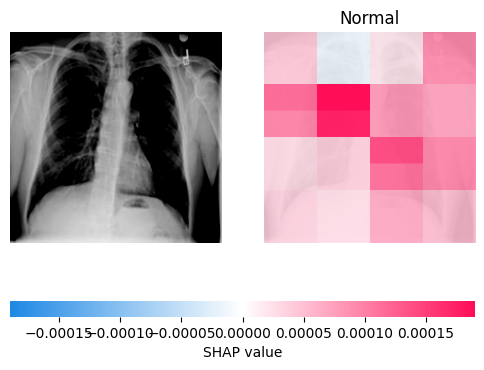

In [190]:
# output with shap values
shap.image_plot(shap_values12345)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


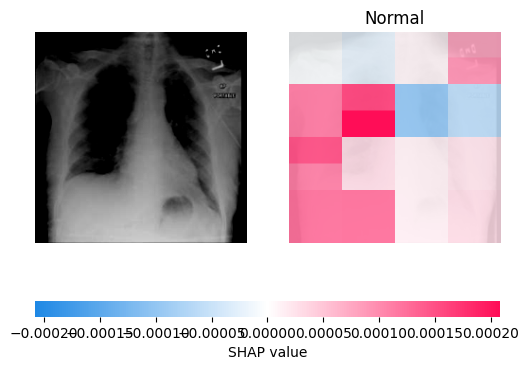

In [195]:
# output with shap values
shap.image_plot(shap_values12500)

In [196]:
combined = shap_values12345 + shap_values12500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


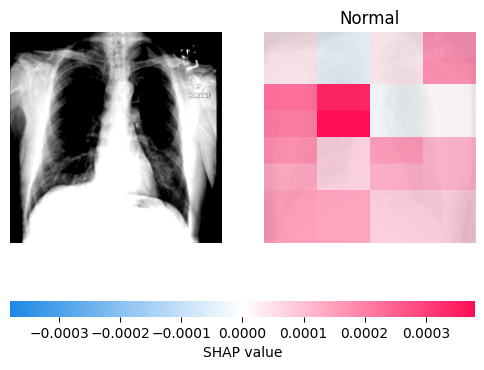

In [197]:
shap.image_plot(combined)

## Combine Shapley Values

In [ ]:
import numpy as np
import shap

In [ ]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir='jpeg')

In [ ]:

class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("covid_radiology_classification")

In [ ]:
# python function to get model output; replace this function with your own model function.
import tensorflow as tf
def f(inputs):
    # print(inputs.shape)
    inputs = inputs.transpose(0,3,1,2)
    inputs = torch.Tensor(inputs)
    with torch.no_grad():
        logits = model(inputs).logits
    # print(logits)
    return logits.numpy()

In [ ]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("covid_radiology_classification")


(1, 224, 224, 3)

In [225]:
test_set = dataset['train']
start_index = 10000
iterations = 10
predictions = []
all_values = None

for i in range(start_index, start_index + iterations):
    image = test_set[i]['image']
    inputs = image_processor(image, return_tensors="pt")
    x_test = inputs['pixel_values'].numpy()
    x_trans = x_test.transpose(0,2,3,1)

    # define a masker that is used to mask out partitions of the input image.
    masker = shap.maskers.Image("blur(128,128)", x_trans[0].shape)

    # create an explainer with model and image masker
    explainer = shap.Explainer(f, masker, output_names=class_names)

    # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
    shap_values = explainer(x_trans, max_evals=2000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
    predictions.append(shap_values.output_names)
    if all_values == None:
        all_values = shap_values
    else:
        all_values += shap_values


PartitionExplainer explainer: 2it [10:05, 605.85s/it]              
PartitionExplainer explainer: 2it [09:49, 589.45s/it]              
PartitionExplainer explainer: 2it [09:56, 596.04s/it]              
PartitionExplainer explainer: 2it [09:38, 578.12s/it]              
PartitionExplainer explainer: 2it [09:38, 578.22s/it]              
PartitionExplainer explainer: 2it [09:39, 579.76s/it]              
PartitionExplainer explainer: 2it [09:39, 579.31s/it]              
PartitionExplainer explainer: 2it [09:36, 576.60s/it]              
PartitionExplainer explainer: 2it [09:38, 578.73s/it]              
PartitionExplainer explainer: 2it [09:39, 579.11s/it]              


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


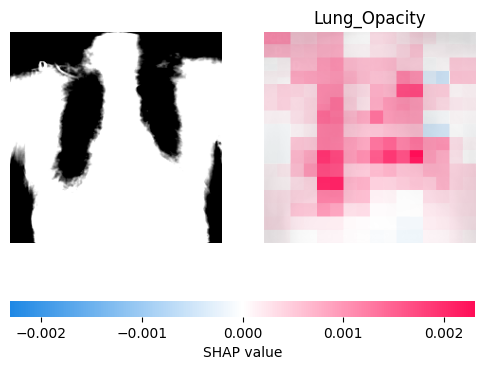

In [203]:
#Covid part 1
shap.image_plot(all_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


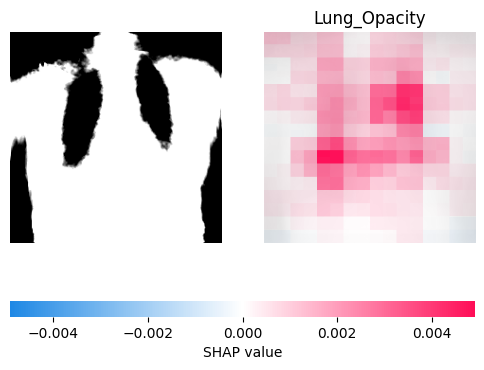

In [219]:
#Covid part 2
shap.image_plot(all_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


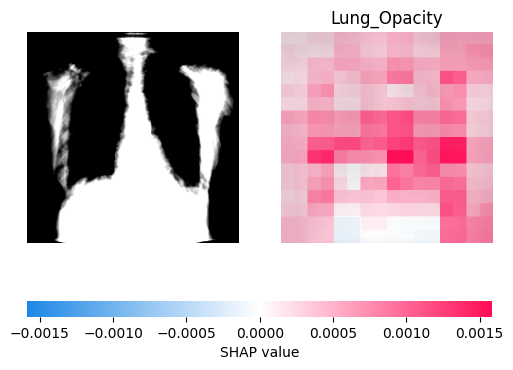

In [226]:
#Normal part 1
shap.image_plot(all_values)

In [227]:
predictions

[['Lung_Opacity'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal']]

# Change png to jpg

In [8]:
from PIL import Image 
import os 

path = 'COVID-19_Radiography_Dataset/Normal/images'

out_path_train = 'COVID-19_Radiography_Dataset/jpeg/train/normal'
out_path_test = 'COVID-19_Radiography_Dataset/jpeg/test/normal'

files = os.listdir(path) # list of files in directory

count = 0

for file in files:  
    count += 1
    if file.endswith('.png'): # check if file is png
        if count <= 8000:
            im = Image.open(f'{path}/'+ file).convert("RGB") # open file as an image object

            im.save(f'{out_path_train}/' + file[:-4] + '.jpg') # save image as jpg with options
        else:
            im = Image.open(f'{path}/'+ file).convert("RGB") # open file as an image object

            im.save(f'{out_path_test}/' + file[:-4] + '.jpg') # save image as jpg with options